## 0.0 IMPORTS

In [142]:
import pandas as  pd
import numpy as np
import inflection 
import math


import seaborn as sns

from matplotlib import pyplot as plt 
from IPython.core.display import HTML
from IPython.display import Image


### 0.1 Helper Functions

In [143]:
def jupyter_settings(): 
     %matplotlib inline 
     %pylab inline


plt.style.use('bmh')
plt.rcParams['figure.figsize'] = [25, 12]
plt.rcParams['font.size'] = 24


display(HTML('<style>.container { width:100% !important; }</style>')) 
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option('display.expand_frame_repr', False)

sns.set()

In [144]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### 0.2 Loading Data

In [145]:
df_sales_raw = pd.read_csv('dataset/train.csv',low_memory=False)
df_store_raw = pd.read_csv('dataset/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 DESCRICAO DOS DADOS

In [146]:
df1 = df_raw.copy()

### 1.1 Raneme columns

In [147]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']


def snakecase(x): return inflection.underscore(x)


cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [148]:
print(f'Number of Rows:',df1.shape[0])
print('Number of cols {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of cols 18


## 1.3 Data Types

In [149]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [150]:
df1['date'] = pd.to_datetime(df1['date'])


## 1.4. Check NA

In [151]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

* CompetitionDistance - distância em metros até a loja concorrente mais próxima
* CompetitionOpenSince[Month/Year] - fornece o ano e o mês aproximados da hora em que o concorrente mais próximo foi aberto
Promo - indica se uma loja está realizando uma promoção naquele dia
* Promo2 - Promo2 é uma promoção contínua e consecutiva para algumas lojas: 0 = loja não está participando, 1 = loja está participando
* Promo2Since[Year/Week] - descreve o ano e a semana do calendário em que a loja começou a participar do Promo2
* PromoInterval - descreve os intervalos consecutivos em que o Promo2 é iniciado, nomeando os meses em que a promoção é reiniciada. Por exemplo. "Fevereiro, maio, agosto, novembro" significa que cada rodada começa em fevereiro, maio, agosto, novembro de qualquer ano para essa loja

In [152]:
# competition_distance   
df1['competition_distance'] = df1['competition_distance'].apply(
    lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month   
df1['competition_open_since_month'] = df1.apply( 
    lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'],axis=1)

# competition_open_since_year    
df1['competition_open_since_year'] = df1.apply(
    lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2                         

# promo2_since_week              
df1['promo2_since_week'] = df1.apply(
    lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year              
df1['promo2_since_year'] = df1.apply(
    lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# coluna mes em string, faz a troca do dicionario do ano para o nome do mes
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
             7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Out', 11: 'Nov', 12: 'Dez'}
# prenche com fillna para nao fazer comparacao com na e todos os na passa como 0 e true para ir diretamentente na coluna
df1['promo_interval'].fillna(0, inplace=True)
# mapear o dic dentro da coluna, transforma a data em date o.dt e depois em mes o month
# passa o month para mapear o dicionario dentro das colunas e que os numeros sejam substituido pelas letras.
df1['month_map'] = df1['date'].dt.month.map(month_map)# extraindo o mes da data, e aplivando o dic para fazer a traducao

# aplicando a condicao para ver se o month_map esta detro dessa condicao para saber se esta na promo ou nao 
# vai me retorna 1 ou zero pela regras de negocio aqui
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(
    lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


## 1.6. Chenge types

In [153]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [154]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int) 


In [155]:
df1.dtypes


store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistics

In [156]:
num_atributes = df1.select_dtypes(include= ['int64','float64'])
cat_atributes = df1.select_dtypes(exclude= ['int64','float64', 'datetime64[ns]'])

## 1.7.1 Numerical Atributes

In [157]:
ct1 = pd.DataFrame( num_atributes.apply(np.mean)).T
ct2 = pd.DataFrame( num_atributes.apply(np.median)).T

d1 = pd.DataFrame( num_atributes.apply(np.std) ).T
d2 = pd.DataFrame( num_atributes.apply(min)).T
d3 = pd.DataFrame( num_atributes.apply(max)).T
d4 = pd.DataFrame( num_atributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame( num_atributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame( num_atributes.apply(lambda x: x.kurtosis())).T

#concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['atributes','min','max','range','mean','median','std','skew','kurtose']
m

,atributes,min,max,range,mean,median,std,skew,kurtose
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


/var/folders/cb/yv1tpd8j3sx6t0rsz1yystv00000gn/T/ipykernel_13686/3247418227.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['competition_distance'],kde=False)


<AxesSubplot:xlabel='competition_distance'>

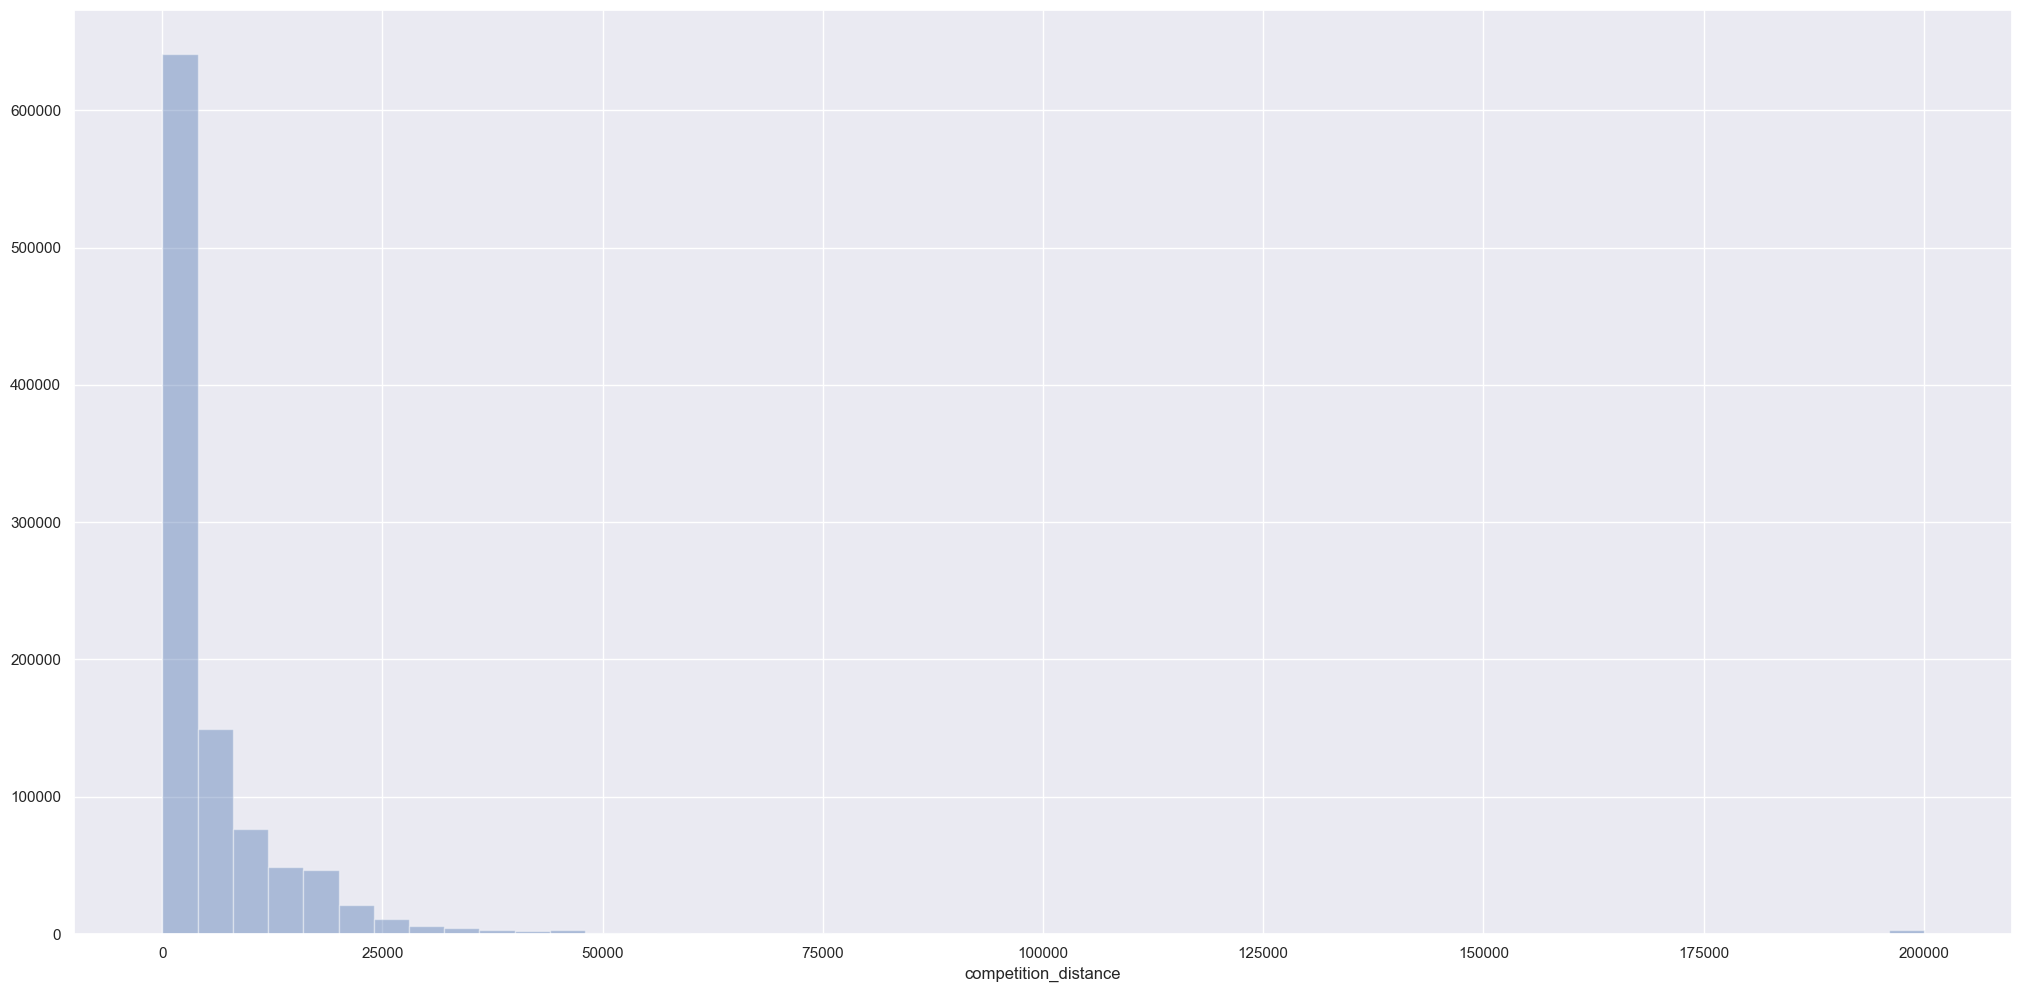

In [158]:
sns.distplot(df1['competition_distance'],kde=False)


## 1.7.2 Categorical Attributes

In [159]:
cat_atributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

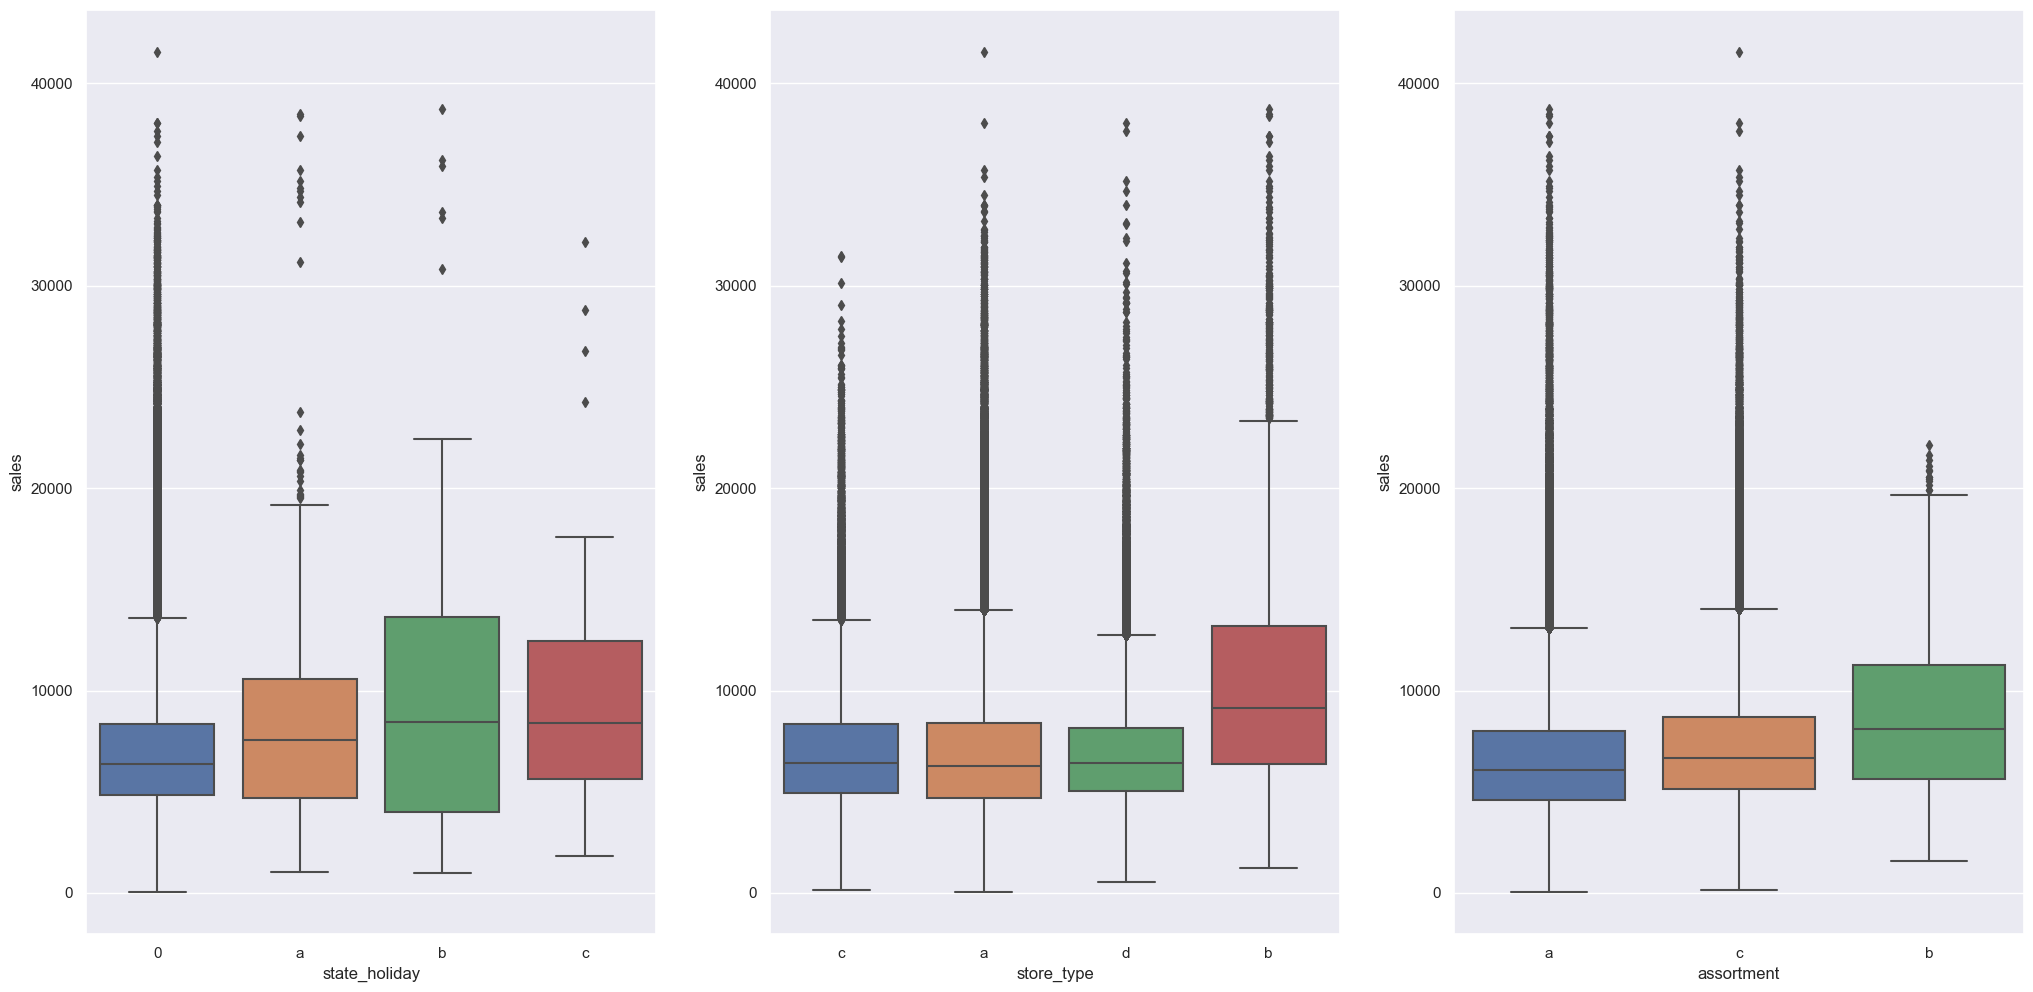

In [160]:
aux1 = df1[(df1['state_holiday']!= 0) & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)


plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)



# 2.0. Feature Engineering

In [161]:
df2 = df1.copy()

## 2.1. Mapa Mental Hipotese

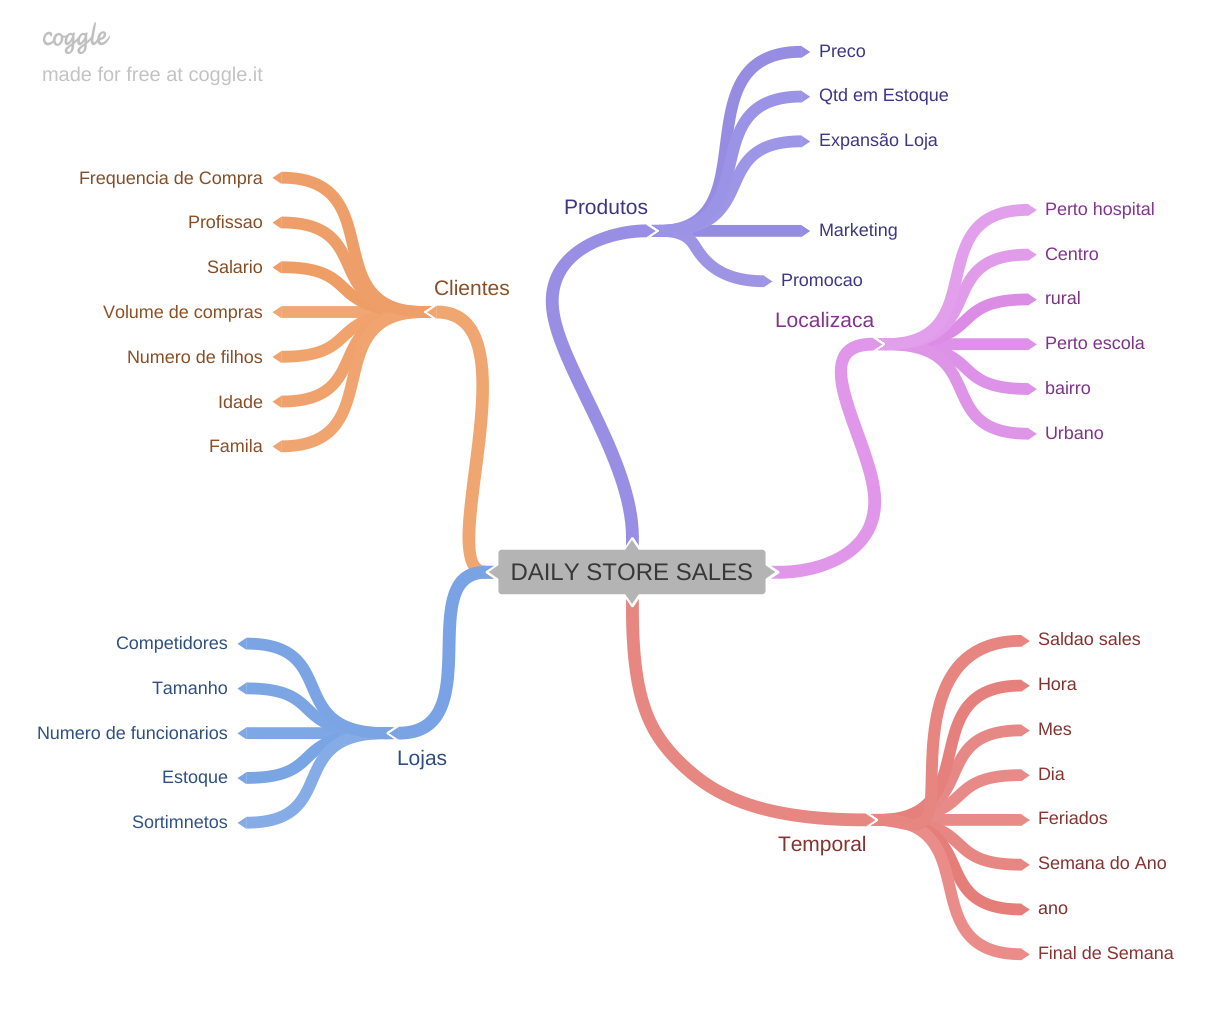

In [162]:
# Mindmap de hipoteses
Image('img/image.png')

### 2.2. Criação das Hipóteses

### 2.2.1. Hipoteses Loja


1. Lojas com número maior de funcionários deveriam vender mais.

2. Lojas com maior capacidade de estoque deveriam vender mais.

3. Lojas com maior porte deveriam vender mais.

4. Lojas com maior sortimentos deveriam vender mais.

5. Lojas com competidores mais próximos deveriam vender menos. 

6. Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2. Hipoteses Produto


1. Lojas que investem mais em Marketing deveriam vender mais.

2. Lojas com maior exposição de produto deveriam vender mais.

3. Lojas com produtos com preço menor deveriam vender mais.

5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

6. Lojas com promoções ativas por mais tempo deveriam vender mais.

7. Lojas com mais dias de promoção deveriam vender mais.

8. Lojas com mais promoções consecutivas deveriam vender mais.


### 2.2.3. Hipoteses Tempo



1. Lojas abertas durante o feriado de Natal deveriam vender mais. 

2. Lojas deveriam vender mais ao longo dos anos.

3. Lojas deveriam vender mais no segundo semestre do ano.

4. Lojas deveriam vender mais depois do dia 10 de cada mês.

5. Lojas deveriam vender menos aos finais de semana.

6. Lojas deveriam vender menos durante os feriados escolares.

### 2.2.3. Hipoteses Tempo



1. Lojas abertas durante o feriado de Natal deveriam vender mais. 2. Lojas deveriam vender mais ao longo dos anos.

3. Lojas deveriam vender mais no segundo semestre do ano.

4. Lojas deveriam vender mais depois do dia 10 de cada mês.
5. Lojas deveriam vender menos aos finais de semana.

6. Lojas deveriam vender menos durante os feriados escolares.



## 2.3. Lista Final de Hipóteses




1. Lojas com maior sortimentos deveriam vender mais.

2. Lojas com competidores mais próximos deveriam vender menos.

3. Lojas com competidores à mais tempo deveriam vendem mais.

4. Lojas com promoções ativas por mais tempo deveriam vender mais.

5. Lojas com mais dias de promoção deveriam vender mais.

7. Lojas com mais promoções consecutivas deveriam vender mais. 

8. Lojas abertas durante o feriado de Natal deveriam vender mais.

 9. Lojas deveriam vender mais ao longo dos anos.

10. Lojas deveriam vender mais no segundo semestre do ano.

11. Lojas deveriam vender mais depois do dia 10 de cada mês.

12. Lojas deveriam vender menos aos finais de semana.

13. Lojas deveriam vender menos durante os feriados escolares.

In [163]:
df2.sample(7)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
502347,268,1,2014-04-07,3833,530,1,0,0,1,a,a,4520.0,2,2014,0,15,2014,0,Apr,0
915345,716,2,2013-04-02,4635,429,1,0,0,1,d,a,3200.0,1,2008,1,22,2011,"Jan,Apr,Jul,Oct",Apr,1
246615,1057,7,2014-12-21,0,0,0,0,0,0,d,c,3230.0,11,2011,0,51,2014,0,Dez,0
228181,722,4,2015-01-08,8084,1282,1,1,0,0,a,a,50.0,1,2015,0,2,2015,0,Jan,0
205125,1081,4,2015-01-29,5362,835,1,1,0,0,b,a,400.0,3,2006,0,5,2015,0,Jan,0
540957,968,2,2014-03-04,9014,1107,1,1,0,0,c,a,1190.0,3,2014,0,10,2014,0,Mar,0
359061,241,5,2014-08-22,7211,747,1,1,0,0,d,c,780.0,8,2014,0,34,2014,0,Aug,0


# 2.3. Feature Engineering

In [164]:
# year
df2['year'] = df2['date'].dt.year

# month_mapday
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(
    year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)

df2['competition_time_month'] = (
    (df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)


# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days ).astype(int)
# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )
# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christimas' if x == 'c' else 'regular_day')


In [165]:
df2.sample(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
711041,457,3,2013-10-02,3629,403,1,0,regular_day,0,d,extended,13140.0,10,2013,1,31,2013,"Jan,Apr,Jul,Oct",Out,0,2013,10,2,40,2013-39,2013-10-01,0,2013-07-29,9
803814,685,4,2013-07-11,7420,726,1,0,regular_day,0,a,basic,650.0,11,2013,1,37,2009,"Jan,Apr,Jul,Oct",Jul,1,2013,7,11,28,2013-27,2013-11-01,-4,2009-09-07,200
423108,194,2,2014-06-17,5742,446,1,1,regular_day,1,d,extended,16970.0,6,2014,1,5,2013,"Feb,May,Aug,Nov",Jun,0,2014,6,17,25,2014-24,2014-06-01,0,2013-01-28,72
520483,564,6,2014-03-22,4921,482,1,0,regular_day,0,d,extended,6540.0,3,2014,1,14,2013,"Jan,Apr,Jul,Oct",Mar,0,2014,3,22,12,2014-11,2014-03-01,0,2013-04-01,50
184047,73,1,2015-02-16,6879,678,1,1,regular_day,0,a,extended,1650.0,9,2008,0,8,2015,0,Fev,0,2015,2,16,8,2015-07,2008-09-01,78,2015-02-16,0


## 3.0.0 Filtragem de Variaveis

In [166]:
df3 = df2.copy()


## 3.1 Fitragem das Linhas

In [167]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]


## 3.2 Seleçao das colunas

In [168]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0. Analise Exploratoria dos Dados

In [176]:
df4 = df3.copy()


## 4.1.Analise Univariada

In [177]:
df4.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
is_promo                                 int64
year                                     int64
month                                    int64
day                                      int64
week_of_year                            UInt32
year_week                               object
competition_s

### 4.1.1 Response Veriables

/var/folders/cb/yv1tpd8j3sx6t0rsz1yystv00000gn/T/ipykernel_13686/3771037661.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df4['sales'])#,kde=False)


<AxesSubplot:xlabel='sales', ylabel='Density'>

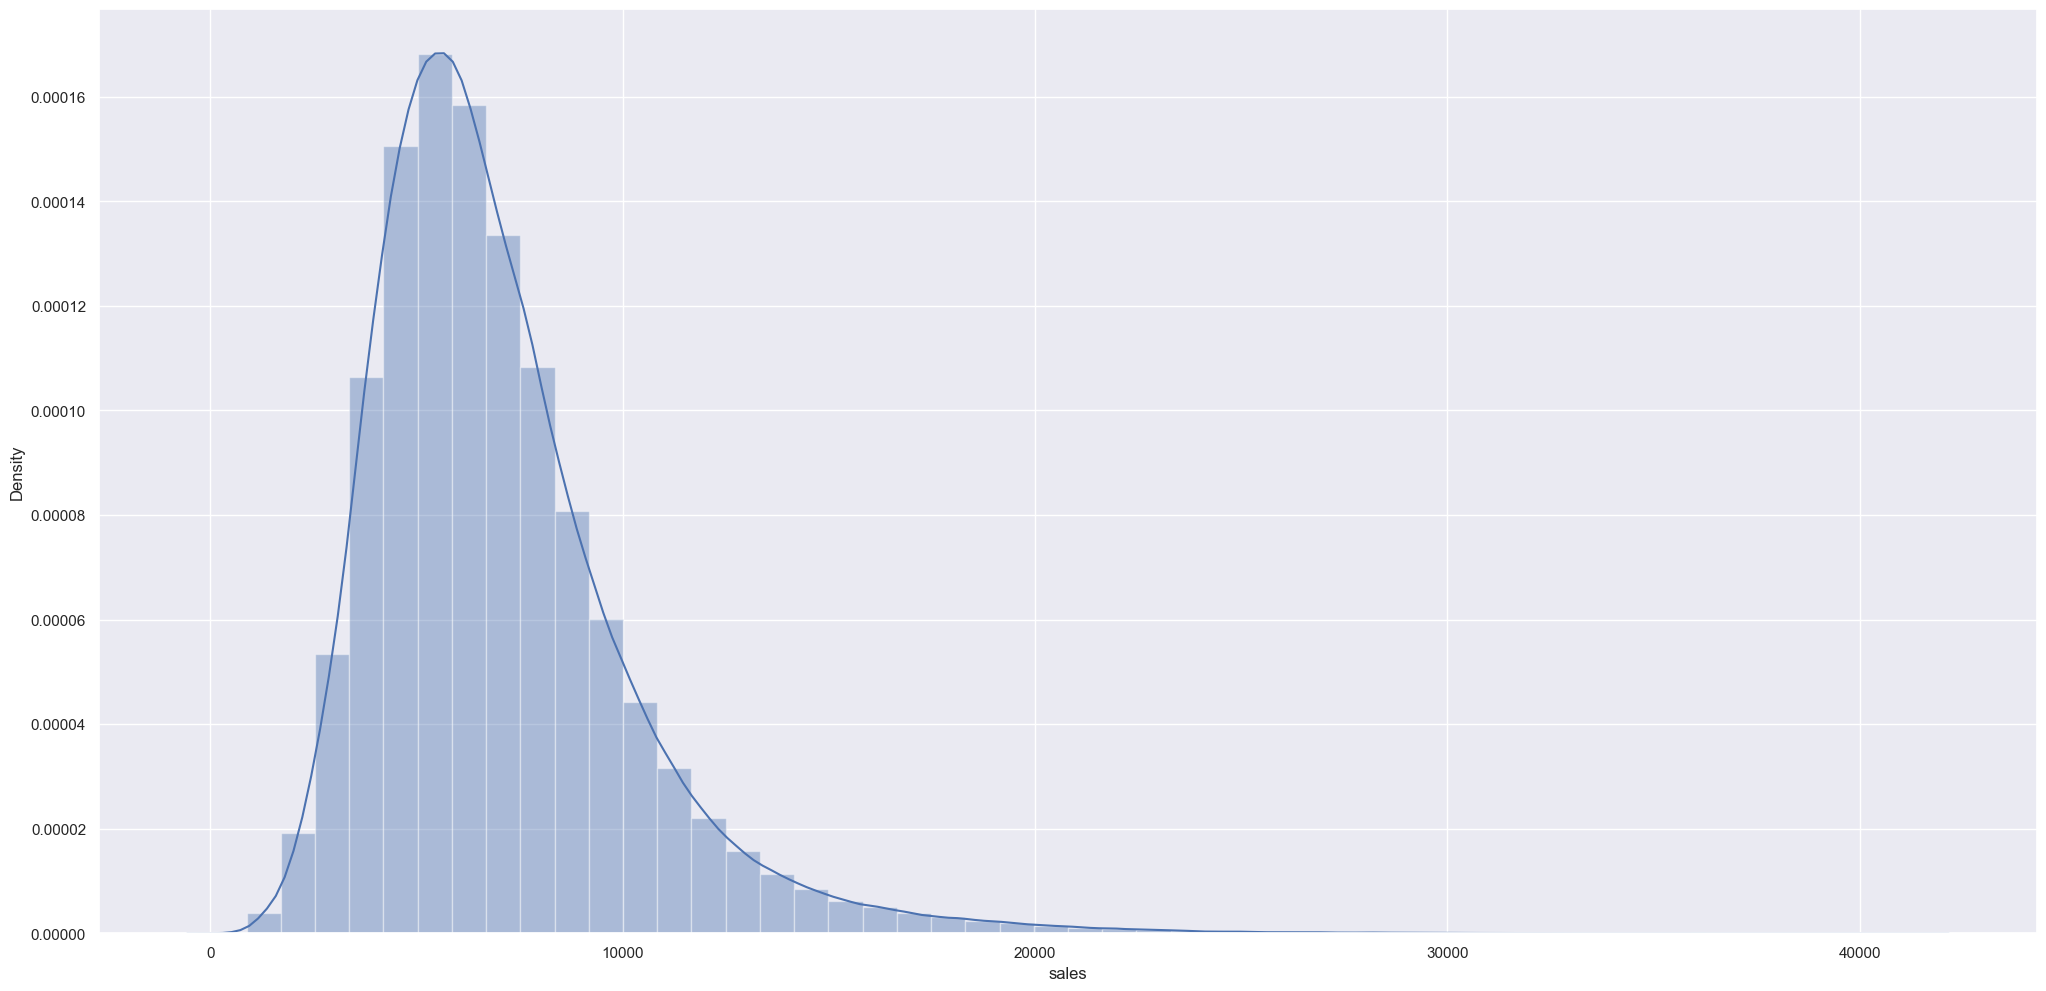

In [178]:
sns.distplot(df4['sales'])#,kde=False)

### 4.1.2 Numerical Veriables

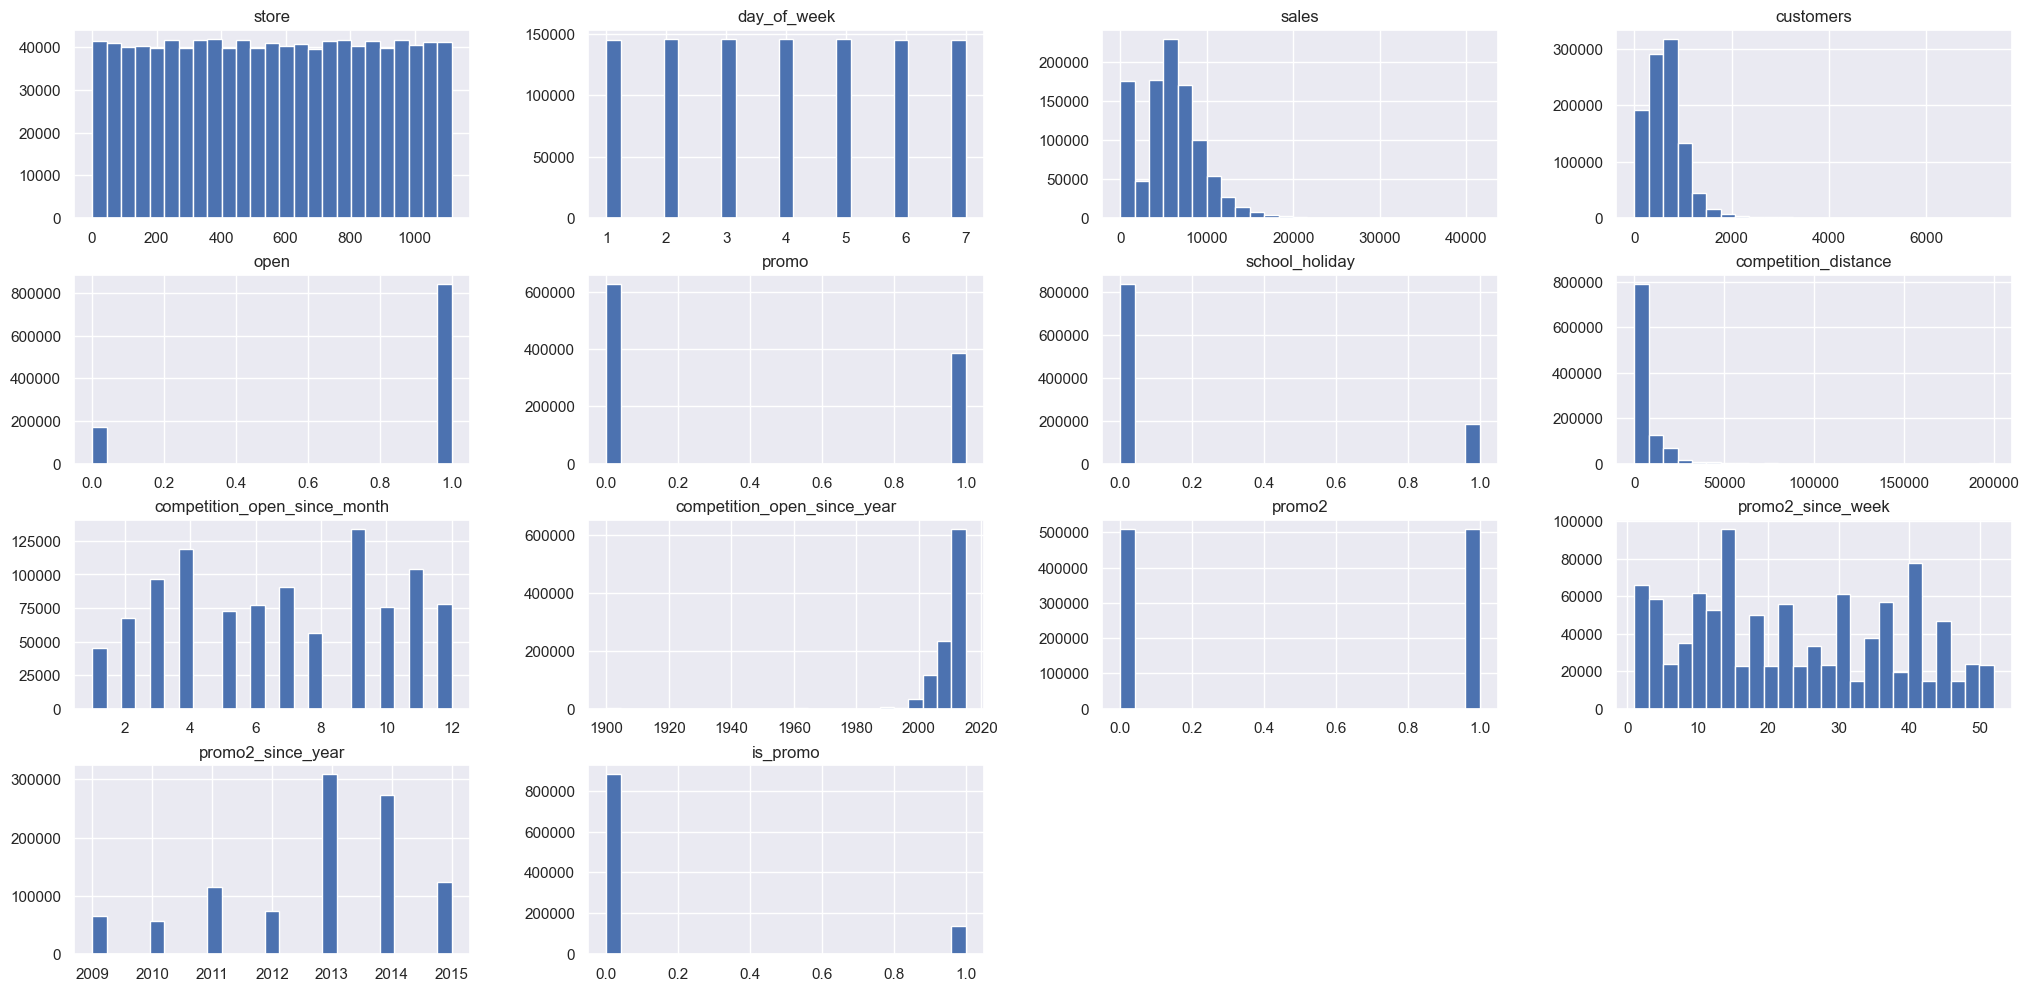

In [179]:
num_atributes.hist( bins=25 );

### 4.1.3 Categorical Veriables

In [180]:
cat_atributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [225]:
df4['assortment'].drop_duplicates()


0         basic
3      extended
258       extra
Name: assortment, dtype: object

## 4.2. Analise Bivariada

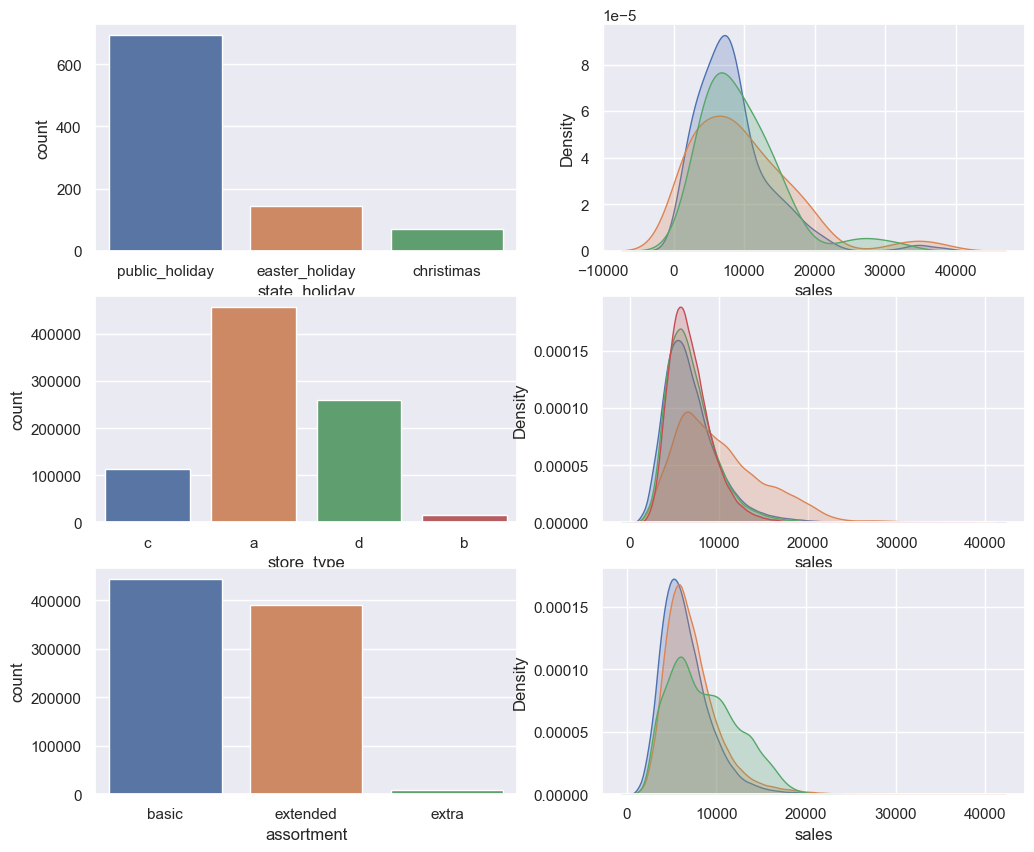

In [240]:
# state_holiday	

# Cria a grade de subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 10))

# Adiciona o primeiro gráfico na posição (0, 0)
d = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x='state_holiday', data=d, ax=axs[0, 0])

# Adiciona o segundo gráfico na posição (0, 1)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']
            ['sales'], label='public_holiday', fill=True, ax=axs[0, 1])

sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']
            ['sales'], label='easter_holiday', fill=True, ax=axs[0, 1])

sns.kdeplot(df4[df4['state_holiday'] == 'christimas']
            ['sales'],label='christimas', fill=True, ax=axs[0, 1])


# store_type

# Adiciona o terceiro gráfico na posição (1, 0)
sns.countplot(x='store_type', data=df4, ax=axs[1, 0])

# Adiciona o quarto gráfico na posição (1, 1)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'],
            label='a', fill=True, ax=axs[1, 1])

sns.kdeplot(df4[df4['store_type'] == 'b']['sales'],
            label='b', fill=True, ax=axs[1, 1])

sns.kdeplot(df4[df4['store_type'] == 'c']['sales'],
            label='c', fill=True, ax=axs[1, 1])

sns.kdeplot(df4[df4['store_type'] == 'd']['sales'],
            label='d', fill=True, ax=axs[1, 1])


# assortment
# Adiciona o quarto gráfico na posição (2, 0)
# b = df4[df4['assortment'] != 'basic']
sns.countplot(x= 'assortment',  data= df4, ax=axs[2,0])

# Adiciona o quarto gráfico na posição (2, 1)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label= 'basei' , fill=True, ax=axs[2,1])
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label= 'extended' , fill=True, ax=axs[2,1])
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label= 'extra' , fill=True, ax=axs[2,1])
    
plt.show()




## 4.3. Analise Multivariada